Encoder-Decoder model

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown 1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC

Downloading...
From (original): https://drive.google.com/uc?id=1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC
From (redirected): https://drive.google.com/uc?id=1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC&confirm=t&uuid=0a1ecf4d-16ec-4c6c-bc43-3158896de4fe
To: /content/glove.6B.100d.txt
100% 347M/347M [00:02<00:00, 118MB/s]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [4]:
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
LATENT_DIM = 512 #LSTM

## 입력 data list 작성  

### 1. input_texts     : original language 의 input text (영어)


### 2. Teacher Forcing 용(디코더용) input / target data 생성 (한국어)

- target_texts_inputs  : 1 만큼 offset 된 target language sentence $\rightarrow$ `<sos>....`  
- target_texts  : target language sentence  $\rightarrow$ `.....<eos>`



- data 는 http://www.manythings.org/anki/  (Tab-delimited Bilingual Sentence Pairs) 에서 download  


    - English(input) + `\t` + The Other Language(target) + `\t` + Attribution(기여자) 형식으로 구성
        ex)
        - Hi.	안녕.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee).
        - I like horses.	나는 말을 좋아해.	CC-BY 2.0 (France) Attribution: tatoeba.org #1331062 (Kirschen112) & #8365125 (Eunhee)
        - We had fun with Tom.	우리는 톰과 즐거운 시간을 가졌다.	CC-BY 2.0 (France) Attribution: tatoeba.org #6845055 (CK) & #6845295 (dalgarak)

        
   

In [5]:
#teacher forcing 용 input, target 작성
file_path = 'kor.txt'

In [6]:
eng_texts = [] #오리지널
kor_inputs = [] #디코더 용 <sos>시작
kor_target = [] #교사학습에서 사용 <eos>종료

for line in open(file_path, 'r', encoding='utf-8'):
  if '\t' not in line:
    continue

  eng, kor, att = line.split('\t')

  input =  '<sos> ' + kor
  target = kor + ' <eos>'

  eng_texts.append(eng)
  kor_inputs.append(input)
  kor_target.append(target)


In [8]:
print(eng_texts)
print(kor_inputs)
print(kor_target)

['Go.', 'Hi.', 'Run!', 'Run.', 'Who?', 'Wow!', 'Fire!', 'Help!', 'Jump!', 'Jump.', 'Wait!', 'Wait!', 'Wait.', 'Begin.', 'Hello!', 'I see.', 'I try.', 'I won!', 'Oh no!', 'Relax.', 'Shoot!', 'Smile.', 'Attack!', 'Attack!', 'Freeze!', 'Get up.', 'Got it!', 'Hug me.', 'I know.', 'I work.', 'Listen.', 'No way!', 'No way!', 'Thanks.', 'We try.', 'We won.', 'Why me?', 'Awesome!', 'Be fair.', 'Beat it.', 'Call us.', 'Come in.', 'Come on!', 'Get out.', 'Go away!', 'Go away.', 'Goodbye!', 'He came.', 'He came.', 'Help me!', 'Help me.', 'Hit Tom.', 'I agree.', "I'm sad.", 'Me, too.', 'Open up.', 'Perfect!', 'Show me.', 'Shut up!', 'Skip it.', 'Stop it.', 'Tell me.', 'Tom won.', 'Wake up!', 'Wash up.', 'Welcome.', 'Welcome.', 'Who won?', 'Why not?', 'Cheer up!', 'Cool off!', 'Get lost.', 'Go ahead.', 'Good job!', 'Grab Tom.', 'How cute!', 'How cute!', 'How deep?', 'Hurry up.', 'I forgot.', "I'm ugly.", 'It hurts.', 'It works.', 'It works.', 'It works.', "Let's go!", 'Look out!', 'Sit down!', 'Sit

In [9]:
print(len(eng_texts))
print(len(kor_inputs))
print(len(kor_target))

3318
3318
3318


In [10]:
#Tokenization
#영어, 한국어를 처리 해야 되기 때문에 tokenizer를 2개 생성
#word_index를 2개 구성

In [7]:
#영어
tokenizer_eng = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_eng.fit_on_texts(eng_texts)

eng_sequences = tokenizer_eng.texts_to_sequences(eng_texts)

print(eng_sequences[1000])
print(eng_texts[1000])

[32, 17, 6, 601, 105]
We have a white cat.


In [12]:
[idx for idx in eng_sequences[1000]]

[32, 17, 6, 601, 105]

In [13]:
tokenizer_eng.index_word[32]

'we'

In [14]:
[tokenizer_eng.index_word[idx] for idx in eng_sequences[1000]]

['we', 'have', 'a', 'white', 'cat']

In [8]:
word2idx_eng = tokenizer_eng.word_index
# word2idx_eng

In [16]:
print(len(word2idx_eng))

2395


In [9]:
#사용할 단어 수 (최대 어휘 크기, 실제 단어 수+1 ==> 둘중 작은 값)
num_words_eng = min(MAX_VOCAB_SIZE,len(word2idx_eng) + 1)
print("Input Text의 단어수 : ", num_words_eng)

Input Text의 단어수 :  2396


In [10]:
max_len_eng = max(len(s) for s in eng_sequences)
print("Input Text의 최대 길이 : ", max_len_eng)

Input Text의 최대 길이 :  101


In [19]:
print(len(word2idx_eng)) #유일한 input token 수
print("Input Text의 단어수 : ", num_words_eng)
print("Input Text의 최대 길이 : ", max_len_eng)

2395
Input Text의 단어수 :  2396
Input Text의 최대 길이 :  101


In [20]:
kor_inputs[0] + kor_target[0]

'<sos> 가.가. <eos>'

In [11]:
tokenizer_kor = Tokenizer(num_words=MAX_VOCAB_SIZE, filters="")

tokenizer_kor.fit_on_texts(kor_inputs + kor_target)

tokenizer_kor.word_index

{'<sos>': 1,
 '<eos>': 2,
 '톰은': 3,
 '난': 4,
 '톰이': 5,
 '있어.': 6,
 '나는': 7,
 '그': 8,
 '내가': 9,
 '수': 10,
 '내': 11,
 '있어?': 12,
 '이': 13,
 '것': 14,
 '네가': 15,
 '너': 16,
 '같아.': 17,
 '않아.': 18,
 '더': 19,
 '할': 20,
 '없어.': 21,
 '거야.': 22,
 '안': 23,
 '것을': 24,
 '좀': 25,
 '걸': 26,
 '그는': 27,
 '왜': 28,
 '해.': 29,
 '이건': 30,
 '적': 31,
 '너무': 32,
 '있는': 33,
 '우린': 34,
 '알고': 35,
 '정말': 36,
 '프랑스어를': 37,
 '사람은': 38,
 '우리는': 39,
 '한': 40,
 '톰을': 41,
 '가장': 42,
 '네': 43,
 '아주': 44,
 '그걸': 45,
 '줄': 46,
 '했어.': 47,
 '잘': 48,
 '있었어.': 49,
 '있다.': 50,
 '계속': 51,
 '넌': 52,
 '건': 53,
 '하고': 54,
 '자기': 55,
 '날': 56,
 '이게': 57,
 '우리': 58,
 '것은': 59,
 '좋아하는': 60,
 '나': 61,
 '아니야.': 62,
 '아직도': 63,
 '얼마나': 64,
 '톰한테': 65,
 '거짓말': 66,
 '하지': 67,
 '있을': 68,
 '사람들은': 69,
 '않았어.': 70,
 '톰의': 71,
 '아직': 72,
 '법을': 73,
 '마.': 74,
 '모두': 75,
 '많이': 76,
 '적이': 77,
 '메리가': 78,
 '그만': 79,
 '싶어.': 80,
 '모든': 81,
 '메리는': 82,
 '누가': 83,
 '못': 84,
 '톰에게': 85,
 '웃었어.': 86,
 '좋은': 87,
 '그렇게': 88,
 '톰과': 89,
 '하는': 90,
 '

In [12]:
kor_input_sequences = tokenizer_kor.texts_to_sequences(kor_inputs)
kor_input_sequences

[[1, 342],
 [1, 1548],
 [1, 1549],
 [1, 1550],
 [1, 1551],
 [1, 1552],
 [1, 870],
 [1, 871],
 [1, 1553],
 [1, 1554],
 [1, 1555],
 [1, 1556],
 [1, 872],
 [1, 460],
 [1, 613],
 [1, 198],
 [1, 1557],
 [1, 9, 1558],
 [1, 1559, 1560],
 [1, 461],
 [1, 870],
 [1, 614],
 [1, 1561],
 [1, 1562],
 [1, 1563],
 [1, 873],
 [1, 1564],
 [1, 1565],
 [1, 199],
 [1, 61, 343],
 [1, 291],
 [1, 135, 62],
 [1, 1566],
 [1, 344],
 [1, 39, 1567],
 [1, 93, 462],
 [1, 28, 1568],
 [1, 1569],
 [1, 1570, 29],
 [1, 345, 342],
 [1, 200, 1571],
 [1, 874],
 [1, 1572],
 [1, 1573],
 [1, 345, 1574],
 [1, 345, 342],
 [1, 613],
 [1, 233, 145],
 [1, 8, 113, 145],
 [1, 871],
 [1, 875],
 [1, 41, 1575],
 [1, 1576],
 [1, 876],
 [1, 1577],
 [1, 1578],
 [1, 1579],
 [1, 877],
 [1, 1580],
 [1, 1581],
 [1, 463],
 [1, 146],
 [1, 5, 462],
 [1, 1582],
 [1, 878, 29],
 [1, 1583],
 [1, 1584],
 [1, 83, 1585],
 [1, 28, 1586],
 [1, 1587],
 [1, 1588],
 [1, 1589],
 [1, 879],
 [1, 1590],
 [1, 41, 1591],
 [1, 1592],
 [1, 174, 1593],
 [1, 64, 1594]

In [13]:
kor_target_sequences = tokenizer_kor.texts_to_sequences(kor_target)
kor_target_sequences

[[342, 2],
 [1548, 2],
 [1549, 2],
 [1550, 2],
 [1551, 2],
 [1552, 2],
 [870, 2],
 [871, 2],
 [1553, 2],
 [1554, 2],
 [1555, 2],
 [1556, 2],
 [872, 2],
 [460, 2],
 [613, 2],
 [198, 2],
 [1557, 2],
 [9, 1558, 2],
 [1559, 1560, 2],
 [461, 2],
 [870, 2],
 [614, 2],
 [1561, 2],
 [1562, 2],
 [1563, 2],
 [873, 2],
 [1564, 2],
 [1565, 2],
 [199, 2],
 [61, 343, 2],
 [291, 2],
 [135, 62, 2],
 [1566, 2],
 [344, 2],
 [39, 1567, 2],
 [93, 462, 2],
 [28, 1568, 2],
 [1569, 2],
 [1570, 29, 2],
 [345, 342, 2],
 [200, 1571, 2],
 [874, 2],
 [1572, 2],
 [1573, 2],
 [345, 1574, 2],
 [345, 342, 2],
 [613, 2],
 [233, 145, 2],
 [8, 113, 145, 2],
 [871, 2],
 [875, 2],
 [41, 1575, 2],
 [1576, 2],
 [876, 2],
 [1577, 2],
 [1578, 2],
 [1579, 2],
 [877, 2],
 [1580, 2],
 [1581, 2],
 [463, 2],
 [146, 2],
 [5, 462, 2],
 [1582, 2],
 [878, 29, 2],
 [1583, 2],
 [1584, 2],
 [83, 1585, 2],
 [28, 1586, 2],
 [1587, 2],
 [1588, 2],
 [1589, 2],
 [879, 2],
 [1590, 2],
 [41, 1591, 2],
 [1592, 2],
 [174, 1593, 2],
 [64, 1594, 2]

In [24]:
print(kor_input_sequences[-1])
print(kor_target_sequences[-1])

[1, 1543, 1544, 193, 5294, 92, 5295, 742, 869, 5296, 5297, 5298, 8, 5299, 5300, 5301, 5302, 396, 611, 458, 5303, 35, 5304, 5305, 195, 5306, 5307, 429, 5308, 427, 8, 611, 274, 330, 1546, 274, 5309, 5310, 48, 5311, 10, 5312, 1547, 1451, 8, 1546, 274, 447, 5313, 5314, 856, 195, 10, 868, 1547, 427, 5315, 93, 13, 590, 167, 33, 5316, 458, 5317, 477, 868, 869, 837, 5318, 5319, 5320, 1542, 869, 837, 5321, 1399, 599, 434, 77, 1398, 385, 68, 269, 5322, 5323, 5324, 10, 68, 22]
[1543, 1544, 193, 5294, 92, 5295, 742, 869, 5296, 5297, 5298, 8, 5299, 5300, 5301, 5302, 396, 611, 458, 5303, 35, 5304, 5305, 195, 5306, 5307, 429, 5308, 427, 8, 611, 274, 330, 1546, 274, 5309, 5310, 48, 5311, 10, 5312, 1547, 1451, 8, 1546, 274, 447, 5313, 5314, 856, 195, 10, 868, 1547, 427, 5315, 93, 13, 590, 167, 33, 5316, 458, 5317, 477, 868, 869, 837, 5318, 5319, 5320, 1542, 869, 837, 5321, 1399, 599, 434, 77, 1398, 385, 68, 269, 5322, 5323, 5324, 10, 68, 22, 2]


In [25]:
tokenizer_kor.index_word[1543]

'의심의'

In [26]:
print([tokenizer_kor.index_word[idx] for idx in kor_input_sequences[-1]])
print([tokenizer_kor.index_word[idx] for idx in kor_target_sequences[-1]])

['<sos>', '의심의', '여지', '없이', '세상에는', '어떤', '남자이든', '정확히', '딱', '알맞는', '여자와', '결혼하거나', '그', '반대의', '상황이', '존재하지.', '그런데', '인간이', '수백', '명의', '사람만', '알고', '지내는', '사이가', '될', '기회를', '갖는다고', '생각해', '보면,', '또', '그', '수백', '명', '중', '열여', '명', '쯤', '이하만', '잘', '알', '수', '있고,', '그리고', '나서', '그', '열여', '명', '중에', '한두', '명만', '친구가', '될', '수', '있다면,', '그리고', '또', '만일', '우리가', '이', '세상에', '살고', '있는', '수백만', '명의', '사람들만', '기억하고', '있다면,', '딱', '맞는', '남자는', '지구가', '생겨난', '이래로', '딱', '맞는', '여자를', '단', '한번도', '만난', '적이', '없을', '수도', '있을', '거라는', '사실을', '쉽게', '눈치챌', '수', '있을', '거야.']
['의심의', '여지', '없이', '세상에는', '어떤', '남자이든', '정확히', '딱', '알맞는', '여자와', '결혼하거나', '그', '반대의', '상황이', '존재하지.', '그런데', '인간이', '수백', '명의', '사람만', '알고', '지내는', '사이가', '될', '기회를', '갖는다고', '생각해', '보면,', '또', '그', '수백', '명', '중', '열여', '명', '쯤', '이하만', '잘', '알', '수', '있고,', '그리고', '나서', '그', '열여', '명', '중에', '한두', '명만', '친구가', '될', '수', '있다면,', '그리고', '또', '만일', '우리가', '이', '세상에', '살고', '있는', '수백만', '명의', '사람들만', '기억하고', '있다면,', '딱', 

In [14]:
word2idx_kor = tokenizer_kor.index_word
word2idx_kor

{1: '<sos>',
 2: '<eos>',
 3: '톰은',
 4: '난',
 5: '톰이',
 6: '있어.',
 7: '나는',
 8: '그',
 9: '내가',
 10: '수',
 11: '내',
 12: '있어?',
 13: '이',
 14: '것',
 15: '네가',
 16: '너',
 17: '같아.',
 18: '않아.',
 19: '더',
 20: '할',
 21: '없어.',
 22: '거야.',
 23: '안',
 24: '것을',
 25: '좀',
 26: '걸',
 27: '그는',
 28: '왜',
 29: '해.',
 30: '이건',
 31: '적',
 32: '너무',
 33: '있는',
 34: '우린',
 35: '알고',
 36: '정말',
 37: '프랑스어를',
 38: '사람은',
 39: '우리는',
 40: '한',
 41: '톰을',
 42: '가장',
 43: '네',
 44: '아주',
 45: '그걸',
 46: '줄',
 47: '했어.',
 48: '잘',
 49: '있었어.',
 50: '있다.',
 51: '계속',
 52: '넌',
 53: '건',
 54: '하고',
 55: '자기',
 56: '날',
 57: '이게',
 58: '우리',
 59: '것은',
 60: '좋아하는',
 61: '나',
 62: '아니야.',
 63: '아직도',
 64: '얼마나',
 65: '톰한테',
 66: '거짓말',
 67: '하지',
 68: '있을',
 69: '사람들은',
 70: '않았어.',
 71: '톰의',
 72: '아직',
 73: '법을',
 74: '마.',
 75: '모두',
 76: '많이',
 77: '적이',
 78: '메리가',
 79: '그만',
 80: '싶어.',
 81: '모든',
 82: '메리는',
 83: '누가',
 84: '못',
 85: '톰에게',
 86: '웃었어.',
 87: '좋은',
 88: '그렇게',
 89: '톰과',
 90: '하는',
 9

In [28]:
print("unique out token: ", len(word2idx_kor))

unique out token:  5324


In [15]:
#사용할 단어 수 계산 (실제 단어 + 1)
num_words_kor = len(word2idx_kor) + 1
print("Target 단어 수: ", num_words_kor)

Target 단어 수:  5325


In [16]:
#Target 최대길이
max_len_kor = max(len(s) for s in kor_target_sequences)
print("Target 최대길이: ", max_len_kor)

Target 최대길이:  90


In [17]:
#sequence padding
#encoder: padding==> pre(단기기억을 잘해서 )
#decoder: paddng==> post

#영어 시퀀스를 패딩 처리하고 인코더의 입력벡터로 변환
encoder_inputs = pad_sequences(eng_sequences, maxlen=max_len_eng, padding = 'pre')
print(type(encoder_inputs))
print(encoder_inputs.shape)
print(encoder_inputs[1000])


<class 'numpy.ndarray'>
(3318, 101)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  32  17   6 601 105]


In [18]:
#한국어 입력 시퀀스를 패딩 처리 디코더의 입력 벡터로 변환
decoder_inputs = pad_sequences(kor_input_sequences, maxlen=max_len_kor, padding='post')
print(decoder_inputs.shape)
print(decoder_inputs[1000])

(3318, 90)
[   1   34 2237  163  187    6    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [19]:
#한국어 타겟 시퀀스를 패딩처리 하고 디코더의 타겟 벡터로 변환
decoder_targets = pad_sequences(kor_target_sequences, maxlen=max_len_kor, padding = 'post')
print(decoder_targets.shape)
print(decoder_targets[1000])

(3318, 90)
[  34 2237  163  187    6    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


## pretrained word embedding 값을 transfer learning

- Embedding layer 의 weight 를 pre-trained model 로 초기화  


- glove.6B 의 EMBEDDING_DIM version 사용  
    - space 로 구분된 text file
    - 첫번째는 word 이고 두번째 이후는 weight vector 값이다


- word index 가 1 부터 시작하므로 0 padding 감안하여 num_words 는 len(word2idx)+1, 혹은 MAX_VOCAB_SIZE 중 작은 것 선택  


- embedding_dict dictionary : key - word, value - embedding_vector

In [34]:
EMBEDDING_DIM
# embedding_dict dictionary : key - word, value - embedding_vector

100

In [20]:
def make_embedding(num_words, embedding_dim, tokenizer, max_vocab_size):
  embeddings_dict = {}

  output = 'glove.6B.100d.txt'
  with open(output, encoding='utf-8') as f:
    for i, line in enumerate(f):
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_dict[word] = coefs
  embedding_matrix = np.zeros((num_words, embedding_dim))
  print("word갯수: ", num_words)
  print(embedding_matrix.shape)
  # Tokenizer의 word_index를 임베딩 매트릭스에 채우기
  for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
      embedding_vector = embeddings_dict.get(word)

      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix
########################################################33



In [21]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx_kor) + 1)
num_words

5325

In [22]:
# embedding layer

# embedding metrix
embedding_matrix = make_embedding(num_words_eng, EMBEDDING_DIM, tokenizer_eng, MAX_VOCAB_SIZE)
# embedding layer
embedding_layer = Embedding(num_words_eng, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True) # trainable: update됨

word갯수:  2396
(2396, 100)


In [23]:
# Encoder model
encoder_inputs = Input(shape=(max_len_eng,), name='Encoder_Input')

# 사전학습된 임베딩 레이어를 재사용(glove.6B)
x = embedding_layer(encoder_inputs)

# LSTM인코더의 출력, 상태(hidden state, cell state)
encoder_outputs, h, c = LSTM(LATENT_DIM, return_state=True)(x)

# encoder의 hidden, cell state를 decoder로 전달(thought vactor)
encoder_states = [h, c]

# 인코더 모델 생성
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)      │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 101, 100)       │       239,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,495,024 (5.70 MB)

 Trainable params: 1,495,024 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Decoder
decoder_inputs = Input(shape=(max_len_kor,), name='Decoder_Input')

decoder_embedding = Embedding(num_words_kor, EMBEDDING_DIM)
decoder_input_x = decoder_embedding(decoder_inputs)

# 교사학습
decoder_lstm = LSTM(LATENT_DIM, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_input_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_kor, activation='softmax', name='Decoder_Output')
decoder_outputs = decoder_dense(decoder_outputs)

# 교사학습
model_teacher_forcing = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_teacher_forcing.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 101, 100)  │    239,600 │ Encoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 90, 100)   │    532,500 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 90, 512), │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Output      │ (None, 90, 5325)  │  2,731,725 │ lstm_1[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,014,673 (22.94 MB)

 Trainable params: 6,014,673 (22.94 MB)

 Non-trainable params: 0 (0.00 B)

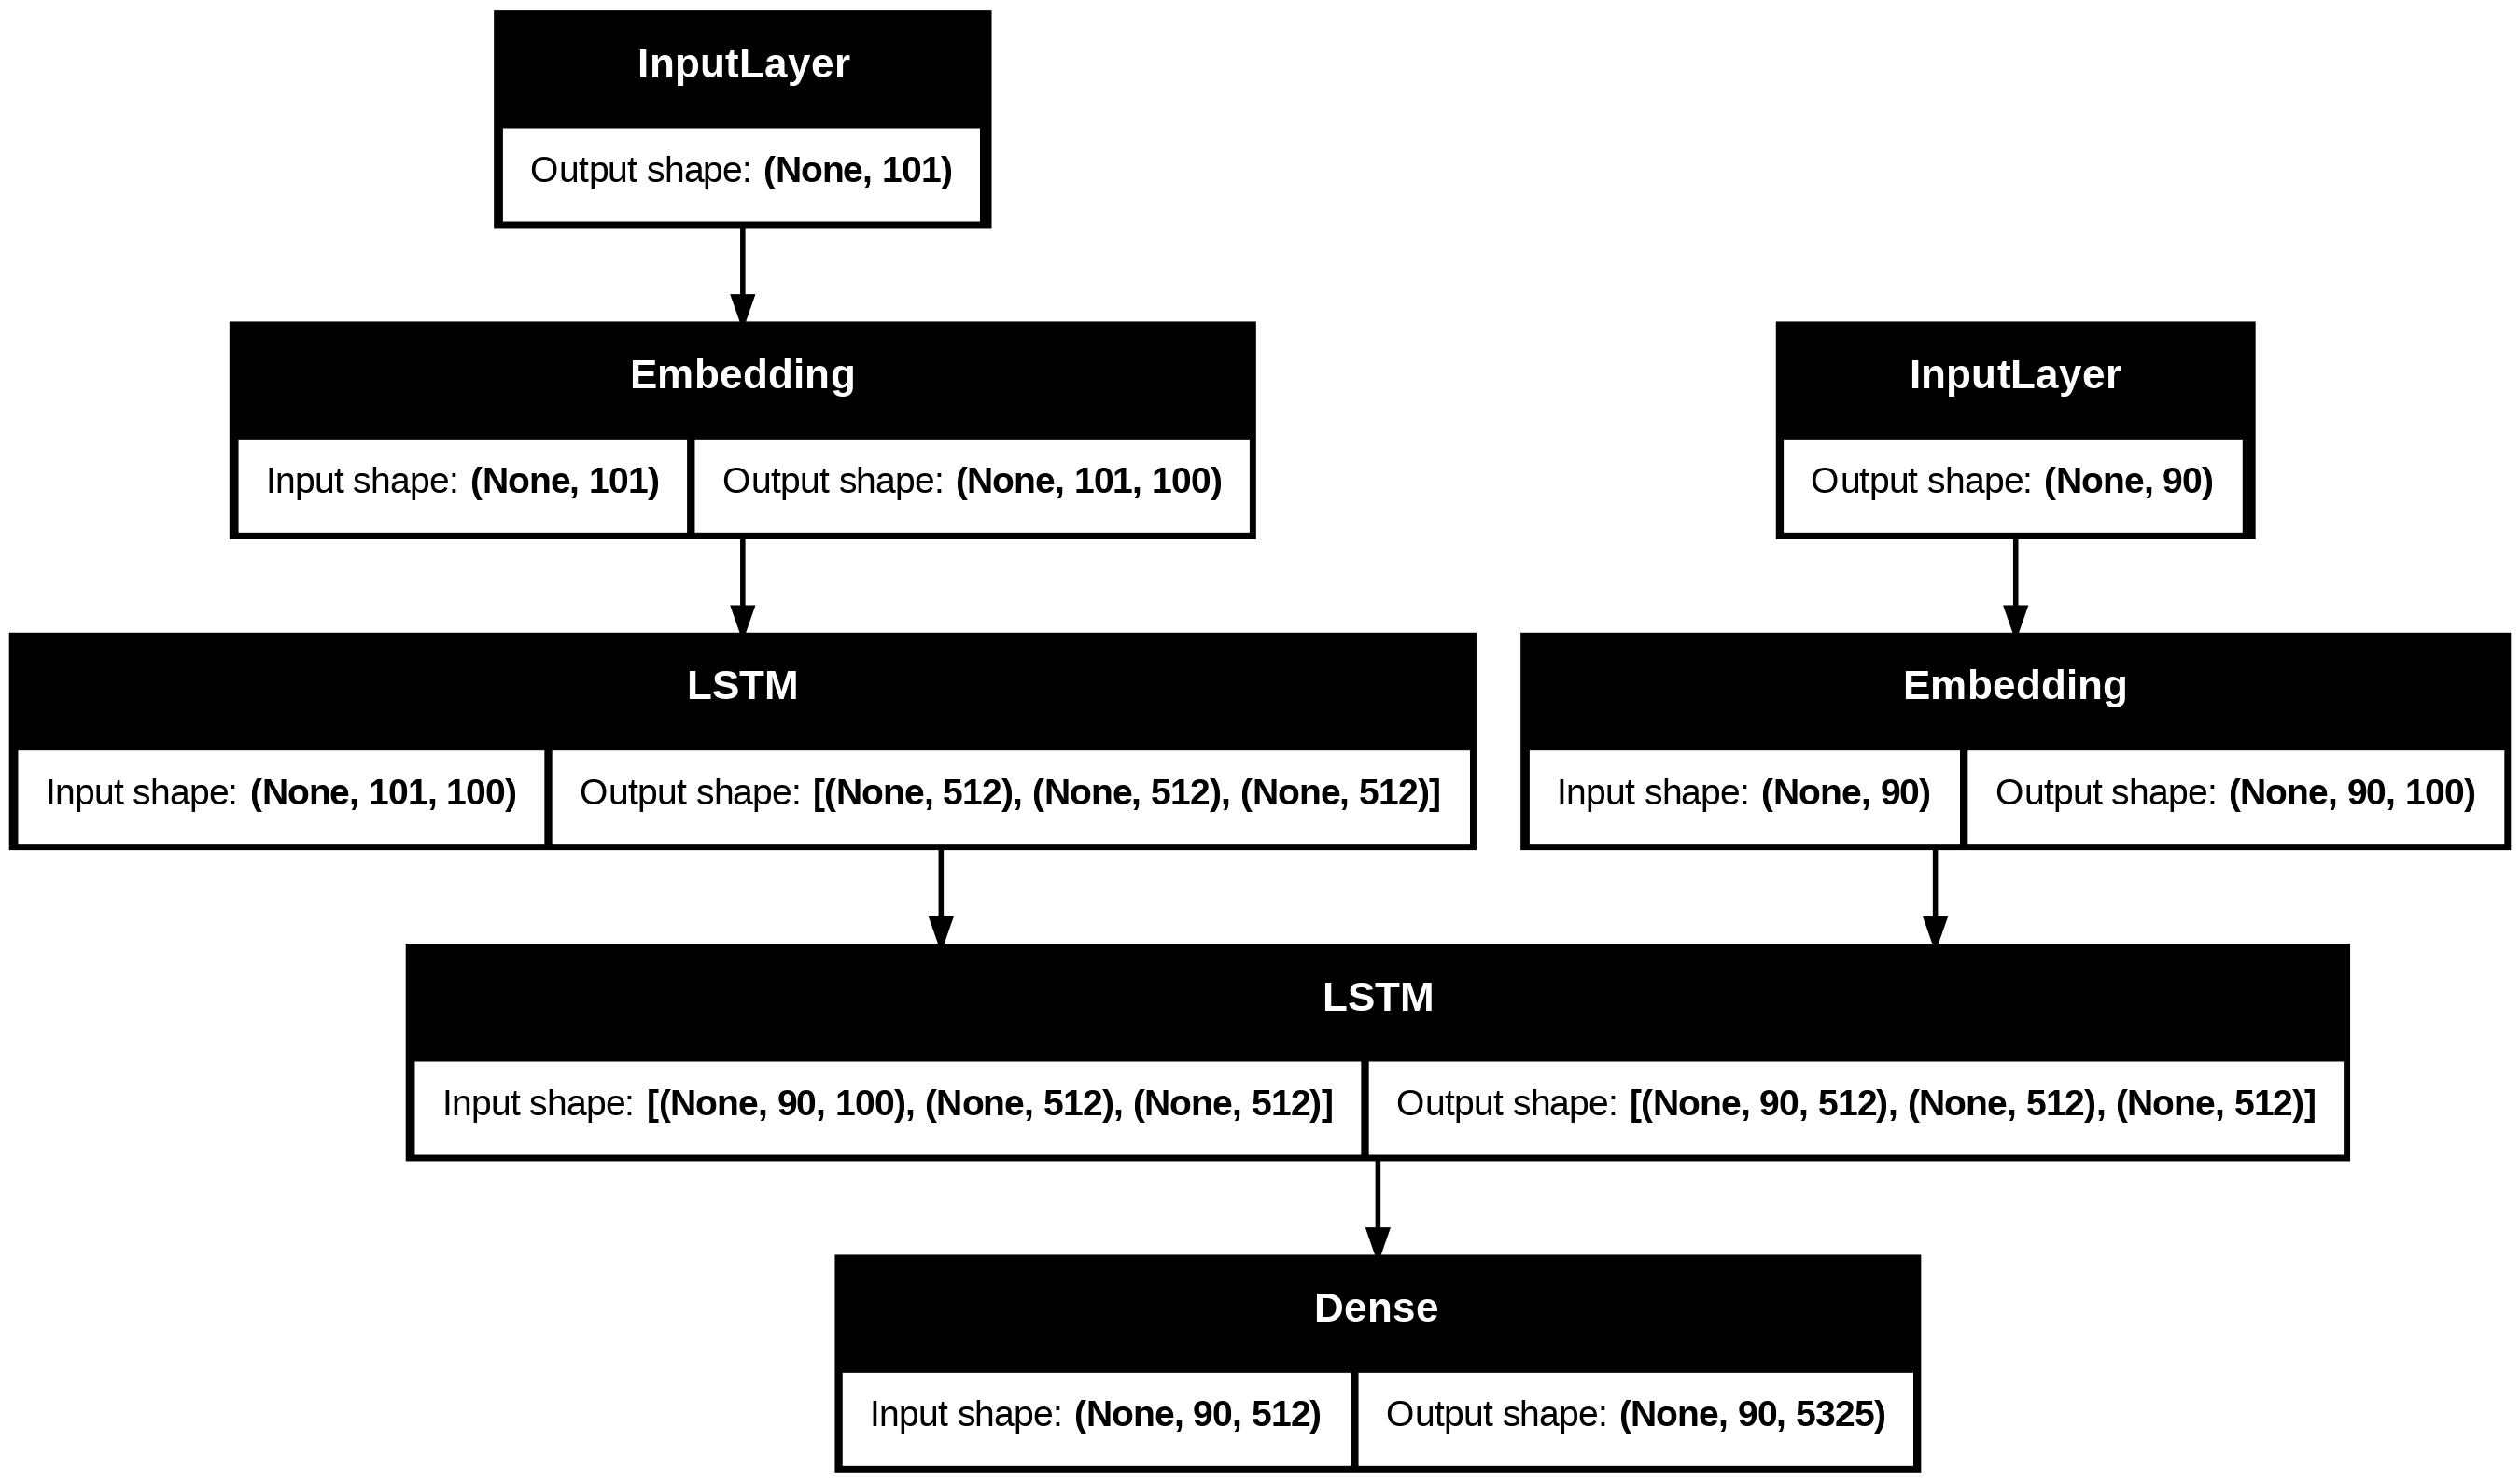

In [26]:
plot_model(model_teacher_forcing, show_shapes=True)

In [32]:
model_teacher_forcing.compile(loss='sparse_categorical_crossentropy',
                              optimizer=Adam(learning_rate=0.001),
                              metrics=['accuracy'])
hist = model_teacher_forcing.fit([encoder_inputs, decoder_inputs],
                                 decoder_targets, batch_size=BATCH_SIZE,
                                 epochs=70, validation_split=0.2)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [31]:
print(encoder_inputs)
print(decoder_inputs)
print(decoder_targets)
print(BATCH_SIZE)
                                #  epochs=70,
                                #  validation_split=0.2

<KerasTensor shape=(None, 101), dtype=float32, sparse=False, ragged=False, name=Encoder_Input>
<KerasTensor shape=(None, 90), dtype=float32, sparse=False, ragged=False, name=Decoder_Input>
[[ 342    2    0 ...    0    0    0]
 [1548    2    0 ...    0    0    0]
 [1549    2    0 ...    0    0    0]
 ...
 [   4 1545  536 ...    0    0    0]
 [ 521 5285  853 ...    0    0    0]
 [1543 1544  193 ...   68   22    2]]
64
